# 导入数据

In [28]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import math
from statsmodels.tsa.arima_model import ARMA
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [29]:
data_file = '大黑楼逐日.csv'
sensor_code='210200D11103009'

In [30]:
data_list_tmp=[]
with open(data_file, 'r', encoding='UTF-8') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0]==sensor_code:
            data_list_tmp.append([datetime(2019,int(row[4]),int(row[5]),0,0),float(row[3])])
start_date=data_list_tmp[0][0]
end_date=data_list_tmp[-1][0]
date_list=pd.date_range(start=start_date,end=end_date).tolist()
data_list=[]
j=0
for i in date_list:
    if data_list_tmp[j][0]==i:
        data_list.append([i,data_list_tmp[j][1]])
        j=j+1
    else:
        data_list.append([i,math.nan])
while math.isnan(data_list[0][1]):
    del(data_list[0])
while math.isnan(data_list[-1][1]):
    del(data_list[-1])
data_set=np.array(data_list)
data_series=pd.Series(data_set[:,1],index=data_set[:,0]).astype(float)

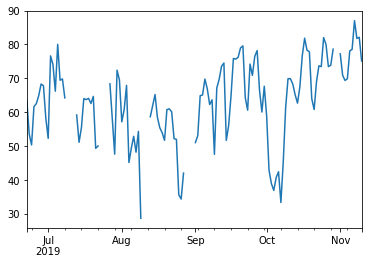

In [31]:
data_series.plot()

# 填补缺失值

In [32]:
data_series=data_series.astype(float).interpolate()

In [33]:
data_series

2019-06-22    63.572
2019-06-23    53.556
2019-06-24    50.338
2019-06-25    61.640
2019-06-26    62.526
               ...  
2019-11-06    78.568
2019-11-07    87.028
2019-11-08    81.768
2019-11-09    82.118
2019-11-10    75.104
Length: 142, dtype: float64

# 划分测试集

In [37]:
train_proportion=0.9
train_length=int(len(data_series)*train_proportion)
test_length=len(data_series)-train_length
data_train=data_series[0:train_length]
data_test=data_series[train_length:]

In [38]:
data_train

2019-06-22    63.572
2019-06-23    53.556
2019-06-24    50.338
2019-06-25    61.640
2019-06-26    62.526
               ...  
2019-10-22    69.018
2019-10-23    73.686
2019-10-24    73.456
2019-10-25    82.024
2019-10-26    79.990
Length: 127, dtype: float64

In [39]:
data_test

2019-10-27    73.462
2019-10-28    73.860
2019-10-29    78.608
2019-10-30    78.146
2019-10-31    77.684
2019-11-01    77.222
2019-11-02    70.908
2019-11-03    69.364
2019-11-04    69.860
2019-11-05    78.078
2019-11-06    78.568
2019-11-07    87.028
2019-11-08    81.768
2019-11-09    82.118
2019-11-10    75.104
dtype: float64

# 成分分解

In [40]:
decomposition=seasonal_decompose(data_train,model='additive')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

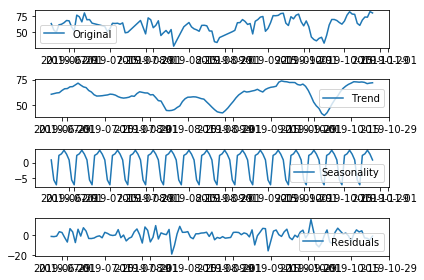

In [41]:
plt.subplot(411)
plt.plot(data_train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 数据预测

In [44]:
p=7
q=1
trend.dropna(inplace=True)
trend_diff=trend.diff(periods=2)
trend_diff.dropna(inplace=True)
order_trend=(p,q)
model_trend=ARMA(trend_diff,order_trend)
result_trend=model_trend.fit()
predict_trend=result_trend.predict()+trend.shift(2)
forecast_trend,_,_=result_trend.forecast(test_length+2)
forecast_trend=pd.Series(forecast_trend,index=pd.DatetimeIndex(start=datetime(data_test.index[0].year,data_test.index[0].month,data_test.index[0].day)+timedelta(days=-2),end=data_test.index[-1],freq='D'))
trend_predict=pd.concat([predict_trend,forecast_trend],axis=0)
for i in range(test_length+2,0,-1):
    trend_predict.values[-i]+=trend_predict[-i-2]

C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # This is added back by InteractiveShellApp.init_path()


In [51]:
value_seasonal=[]
diff=datetime(data_test.index[0].year,data_test.index[0].month,data_test.index[0].day)-datetime(data_train.index[0].year,data_train.index[0].month,data_train.index[0].day)
shift=diff.days%7
for i in range(test_length):
    value_seasonal.append(seasonal.values[i+shift])
forecast_seasonal=pd.Series(value_seasonal,index=pd.DatetimeIndex(start=datetime(data_test.index[0].year,data_test.index[0].month,data_test.index[0].day),end=data_test.index[-1],freq='D'))
seasonal_predict=pd.concat([seasonal,forecast_seasonal],axis=0)

C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


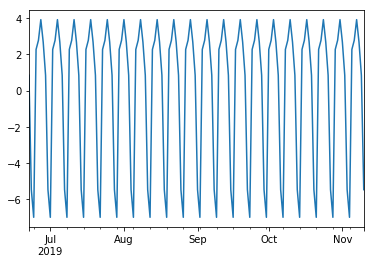

In [52]:
seasonal_predict.plot()

In [53]:
residual.dropna(inplace=True)
order_residual=sm.tsa.stattools.arma_order_select_ic(residual)['bic_min_order']
model_residual=ARMA(residual,order_residual)
result_residual=model_residual.fit()
predict_residual=result_residual.predict()
forecast_residual,_,_=result_residual.forecast(test_length+2)
forecast_residual=pd.Series(forecast_residual,index=pd.DatetimeIndex(start=datetime(data_test.index[0].year,data_test.index[0].month,data_test.index[0].day)+timedelta(days=-2),end=data_test.index[-1],freq='D'))
residual_predict=pd.concat([predict_residual,forecast_residual],axis=0)

C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Administrator\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  import sys


In [54]:
test_data=trend_predict+seasonal_predict+residual_predict
print(test_data)

2019-06-22          NaN
2019-06-23          NaN
2019-06-24          NaN
2019-06-25          NaN
2019-06-26          NaN
                ...    
2019-11-06    76.399539
2019-11-07    78.147304
2019-11-08    76.057868
2019-11-09    75.061905
2019-11-10    67.923328
Length: 142, dtype: float64


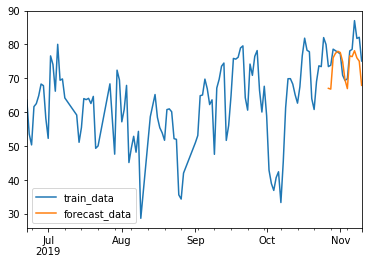

In [57]:
data_series.plot(label='train_data',legend=True)
test_data[-test_length:].plot(label='forecast_data',legend=True)
plt.show()

In [56]:
accuracy=1-(abs(test_data-data_series)/data_series)[train_length:].mean()
print(accuracy)

0.9510261084527522
